In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tifffile import imread
import h5py
import matplotlib.pyplot as plt
from scripts.sample_db import SampleDB

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3', '20220118_RM0012_124hpf_fP8_f2', '20220427_RM0008_126hpf_fP3_f3'])


In [2]:

# Loading experiment
sample_id = '20220118_RM0012_124hpf_fP8_f2'  
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Making shortcuts of sample parameters/information
sample = exp.sample
trials_path = exp.paths.trials_path
n_planes = exp.params_lm.n_planes
n_trials = exp.params_lm.n_trials
doubling = 2 if exp.params_lm.doubling else 1

# Getting paths of the trial acquisitions
trial_names = os.listdir(os.path.join(trials_path, 'raw'))
processed_folder = os.path.join(trials_path, 'processed')
masks_folder = os.path.join(trials_path, "masks")

# Load the masks
masks_file = glob.glob(os.path.join(masks_folder, f'masks_{exp.sample.id}_*.tif'))[0]
masks_stack = imread(masks_file)

# Create folder for saving fluorescence data
traces_folder = os.path.join(trials_path, "traces")
os.makedirs(traces_folder, exist_ok=True)

hdf5_file_path = os.path.join(traces_folder, f'{exp.sample.id}_fluorescence_data.h5')

# Function to process and save data
def extract_fluorescence_data(hdf5_file_path, sample_id, trial_names, processed_folder, masks_stack, n_planes, doubling):
    with h5py.File(hdf5_file_path, 'w') as f:
        exp_grp = f.create_group(sample_id)
        
        all_traces, all_labels, all_planes, all_trials, all_odors, all_centroids = [], [], [], [], [], []
        
        for trial_idx, trial_path in enumerate(trial_names):
            movie_path = os.path.join(processed_folder, f"motion_corrected_{trial_path}")
            movie = imread(movie_path)
            print(f"Processing trial {trial_idx + 1}/{len(trial_names)}, shape: {movie.shape}")

            trial_info = trial_path.split('_')
            trial_num = trial_info[5][1:]
            odor_full = trial_info[6][2:]
            odor = odor_full[2:] if odor_full.startswith('o') else odor_full

            for plane in range(n_planes * doubling):
                plane_movie = movie[plane]
                mask = masks_stack[plane, trial_idx, :, :]

                for label in np.unique(mask):
                    if label != 0:
                        label_mask = mask == label
                        fluorescence_values = plane_movie[:, label_mask].mean(axis=1)
                        
                        all_traces.append(fluorescence_values)
                        all_labels.append(label)
                        all_planes.append(plane)
                        all_trials.append(trial_num)
                        all_odors.append(odor)

                        y, x = np.where(label_mask)
                        centroid = (np.mean(y), np.mean(x))
                        all_centroids.append(centroid)

        # Save data in HDF5 file
        exp_grp.create_dataset('raw_traces', data=np.array(all_traces))
        exp_grp.create_dataset('lm_plane_labels', data=np.array(all_labels))
        exp_grp.create_dataset('plane_nr', data=np.array(all_planes))
        exp_grp.create_dataset('trial_nr', data=np.array(all_trials, dtype='S'))
        exp_grp.create_dataset('odor', data=np.array(all_odors, dtype='S'))
        exp_grp.create_dataset('lm_plane_centroids', data=np.array(all_centroids))

        # Create a mapping group
        mapping_grp = exp_grp.create_group('cell_mapping')
        mapping_grp.create_dataset('neuron_ids', data=np.array([f'n{i}' for i in range(1, len(all_labels) + 1)], dtype='S'))
        mapping_grp.create_dataset('lm_plane_labels', data=np.array(all_labels))
        mapping_grp.create_dataset('plane_nr', data=np.array(all_planes))

    print("Fluorescence intensities calculated and saved in HDF5 file.")

# Process and save data
extract_fluorescence_data(hdf5_file_path, sample_id, trial_names, processed_folder, masks_stack, n_planes, doubling)

    
   

20220118_RM0012_124hpf_fP8_f2


IndexError: list index out of range

In [3]:
 # Plot extracted raw traces
def load_data(hdf5_file_path, sample_id):
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[sample_id]
        return {key: exp_grp[key][()] for key in exp_grp.keys() if isinstance(exp_grp[key], h5py.Dataset)}

# Load data
data = load_data(hdf5_file_path, sample_id)
print(data.keys())

dict_keys(['lm_plane_centroids', 'lm_plane_labels', 'odor', 'plane_nr', 'raw_traces', 'trial_nr'])

In [ ]:
# Plot the first three traces
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(data['raw_traces'][i], label=f'Label {data["lm_plane_labels"][i]}')

plt.title('Fluorescence Intensity Traces')
plt.xlabel('Time (frames)')
plt.ylabel('Fluorescence Intensity')
plt.legend()
plt.show()

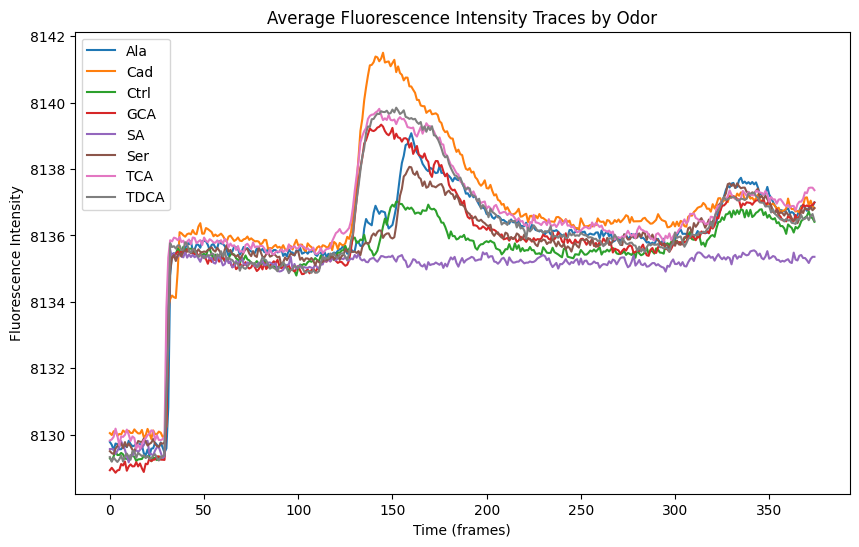

In [7]:


# Plot average traces for each odor
odors_name = np.unique(data['odor'])
plt.figure(figsize=(10, 6))
for odor in odors_name:
    plt.plot(data['raw_traces'][data['odor'] == odor].mean(axis=0), label=odor.decode('utf-8'))
plt.legend()
plt.title('Average Fluorescence Intensity Traces by Odor')
plt.xlabel('Time (frames)')
plt.ylabel('Fluorescence Intensity')
plt.show()

